# Lab 4: Data Imputation using an Autoencoder


In this lab, you will build and train an autoencoder to impute (or "fill in") missing data.

We will be using the
Adult Data Set provided by the UCI Machine Learning Repository [1], available
at https://archive.ics.uci.edu/ml/datasets/adult.
The data set contains census record files of adults, including their
age, martial status, the type of work they do, and other features.

Normally, people use this data set to build a supervised classification
model to classify whether a person is a high income earner.
We will not use the dataset for this original intended purpose.

Instead, we will perform the task of imputing (or "filling in") missing values in the dataset. For example,
we may be missing one person's martial status, and another person's age, and
a third person's level of education. Our model will predict the missing features
based on the information that we do have about each person.

We will use a variation of a denoising autoencoder to solve this data imputation
problem. Our autoencoder will be trained using inputs that have one categorical feature artificially
removed, and the goal of the autoencoder is to correctly reconstruct all features,
including the one removed from the input.

In the process, you are expected to learn to:

1. Clean and process continuous and categorical data for machine learning.
2. Implement an autoencoder that takes continuous and categorical (one-hot) inputs.
3. Tune the hyperparameters of an autoencoder.
4. Use baseline models to help interpret model performance.

[1] Dua, D. and Karra Taniskidou, E. (2017). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.


### What to submit

Submit a PDF file containing all your code, outputs, and write-up. You can produce a PDF of your Google Colab file by going to File > Print and then save as PDF. The Colab instructions have more information.

Do not submit any other files produced by your code.

Include a link to your colab file in your submission.


## Colab Link

Include a link to your Colab file here. If you would like the TA to look at your
Colab file in case your solutions are cut off, **please make sure that your Colab
file is publicly accessible at the time of submission**.

Colab Link: https://colab.research.google.com/drive/1n1mvgU_0z9Rb8uv_gW_ujk9G6dGYea3u?usp=sharing

In [ ]:
%%shell
jupyter nbconvert --to html /content/Lab4_Data_Imputation.ipynb

[NbConvertApp] Converting notebook /content/Lab4_Data_Imputation.ipynb to html
[NbConvertApp] Writing 1281593 bytes to /content/Lab4_Data_Imputation.html


In [ ]:
import csv
import numpy as np
import random
import torch
import torch.utils.data

## Part 0

We will be using a package called `pandas` for this assignment.

If you are using Colab, `pandas` should already be available.
If you are using your own computer,
installation instructions for `pandas` are available here:
https://pandas.pydata.org/pandas-docs/stable/install.html

In [ ]:
import pandas as pd

# Part 1. Data Cleaning [15 pt]

The adult.data file is available at `https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data`

The function `pd.read_csv` loads the adult.data file into a pandas dataframe.
You can read about the pandas documentation for `pd.read_csv` at
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html

In [ ]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [ ]:
header = ['age', 'work', 'fnlwgt', 'edu', 'yredu', 'marriage', 'occupation',
 'relationship', 'race', 'sex', 'capgain', 'caploss', 'workhr', 'country']
df = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
    names=header,
    index_col=False)

<ipython-input-4-037957db2593>:3: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  df = pd.read_csv(


In [ ]:
df.shape # there are 32561 rows (records) in the data frame, and 14 columns (features)

(32561, 14)

### Part (a) Continuous Features [3 pt]

For each of the columns `["age", "yredu", "capgain", "caploss", "workhr"]`, report the minimum, maximum, and average value across the dataset.

Then, normalize each of the features `["age", "yredu", "capgain", "caploss", "workhr"]`
so that their values are always between 0 and 1.
Make sure that you are actually modifying the dataframe `df`.

Like numpy arrays and torch tensors,
pandas data frames can be sliced. For example, we can
display the first 3 rows of the data frame (3 records) below.

In [ ]:
df[:3] # show the first 3 records

,age,work,fnlwgt,edu,yredu,marriage,occupation,relationship,race,sex,capgain,caploss,workhr,country
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States


Alternatively, we can slice based on column names,
for example `df["race"]`, `df["hr"]`, or even index multiple columns
like below.

In [ ]:
subdf = df[["age", "yredu", "capgain", "caploss", "workhr"]]
subdf[:3] # show the first 3 records

,age,yredu,capgain,caploss,workhr
0,39,13,2174,0,40
1,50,13,0,0,13
2,38,9,0,0,40


Numpy works nicely with pandas, like below:

In [ ]:
np.sum(subdf["caploss"])

2842700

Just like numpy arrays, you can modify
entire columns of data rather than one scalar element at a time.
For example, the code  

`df["age"] = df["age"] + 1`

would increment everyone's age by 1.

In [ ]:
min = subdf.min()
print("Minimum in age, yredu, capgain, caploss, workhr")
print(min)
max = subdf.max()
print("Maximum in age, yredu, capgain, caploss, workhr")
print(max)
avg = subdf.mean()
print("Average in age, yredu, capgain, caploss, workhr")
print(avg)

#normalize
df["age"]=(subdf["age"]-subdf["age"].min())/(subdf["age"].max()-subdf["age"].min())
df["yredu"]=(subdf["yredu"]-subdf["yredu"].min())/(subdf["yredu"].max()-subdf["yredu"].min())
df["capgain"]=(subdf["capgain"]-subdf["capgain"].min())/(subdf["capgain"].max()-subdf["capgain"].min())
df["caploss"]=(subdf["caploss"]-subdf["caploss"].min())/(subdf["caploss"].max()-subdf["caploss"].min())
df["workhr"]=(subdf["workhr"]-subdf["workhr"].min())/(subdf["workhr"].max()-subdf["workhr"].min())


Minimum in age, yredu, capgain, caploss, workhr
age        17
yredu       1
capgain     0
caploss     0
workhr      1
dtype: int64
Maximum in age, yredu, capgain, caploss, workhr
age           90
yredu         16
capgain    99999
caploss     4356
workhr        99
dtype: int64
Average in age, yredu, capgain, caploss, workhr
age          38.581647
yredu        10.080679
capgain    1077.648844
caploss      87.303830
workhr       40.437456
dtype: float64


### Part (b) Categorical Features [1 pt]

What percentage of people in our data set are male? Note that the data labels all have an unfortunate space in the beginning, e.g. " Male" instead of "Male".

What percentage of people in our data set are female?

In [ ]:
# hint: you can do something like this in pandas
male = sum(df["sex"] == " Male")
female = sum(df["sex"] == " Female")
per_male = male*100/(male+female)
per_female = female*100/(male+female)

print("percentage of male", per_male, "%")
print("percentage of female", per_female, "%")

percentage of male 66.92054912318417 %
percentage of female 33.07945087681582 %


### Part (c) [2 pt]

Before proceeding, we will modify our data frame in a couple more ways:

1. We will restrict ourselves to using a subset of the features (to simplify our autoencoder)
2. We will remove any records (rows) already containing missing values, and store them in a second dataframe. We will only use records without missing values to train our autoencoder.

Both of these steps are done for you, below.

How many records contained missing features? What percentage of records were removed?

In [ ]:
contcols = ["age", "yredu", "capgain", "caploss", "workhr"]
catcols = ["work", "marriage", "occupation", "edu", "relationship", "sex"]
features = contcols + catcols
df = df[features]

In [ ]:
missing = pd.concat([df[c] == " ?" for c in catcols], axis=1).any(axis=1)
df_with_missing = df[missing]
print("number of records contained missing features:", df_with_missing.shape[0])
df_not_missing = df[~missing]
print("percentage of missing features removed:", df_with_missing.shape[0]*100/(df_not_missing.shape[0]+df_with_missing.shape[0]), "%")

number of records contained missing features: 1843
percentage of missing features removed: 5.660145572924664 %


### Part (d) One-Hot Encoding [1 pt]

What are all the possible values of the feature "work" in `df_not_missing`? You may find the Python function `set` useful.

In [ ]:
set(df_not_missing["work"])

{' Federal-gov',
 ' Local-gov',
 ' Private',
 ' Self-emp-inc',
 ' Self-emp-not-inc',
 ' State-gov',
 ' Without-pay'}

We will be using a one-hot encoding to represent each of the categorical variables.
Our autoencoder will be trained using these one-hot encodings.

We will use the pandas function `get_dummies` to produce one-hot encodings
for all of the categorical variables in `df_not_missing`.

In [ ]:
data = pd.get_dummies(df_not_missing)

In [ ]:
data[:3]

,age,yredu,capgain,caploss,workhr,work_ Federal-gov,work_ Local-gov,work_ Private,work_ Self-emp-inc,work_ Self-emp-not-inc,...,edu_ Prof-school,edu_ Some-college,relationship_ Husband,relationship_ Not-in-family,relationship_ Other-relative,relationship_ Own-child,relationship_ Unmarried,relationship_ Wife,sex_ Female,sex_ Male
0,0.301370,0.800000,0.02174,0.0,0.397959,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
1,0.452055,0.800000,0.00000,0.0,0.122449,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,1
2,0.287671,0.533333,0.00000,0.0,0.397959,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,1


### Part (e) One-Hot Encoding [2 pt]

The dataframe `data` contains the cleaned and normalized data that we will use to train our denoising autoencoder.

How many **columns** (features) are in the dataframe `data`?

Briefly explain where that number come from.

In [ ]:
print("number of columns in the dataframe data:", len(data.columns))

number of columns in the dataframe data: 57


Because we are now using one hot encoding for representing each of the categorial variables. So each 1 column before is transfered into the number of distinct feature that it have. For example, the work column before is changed to 7 (7 distinct feature for work) new columns in data. Similar applies for other columns. So now the number of columns have increased.

### Part (f) One-Hot Conversion [3 pt]

We will convert the pandas data frame `data` into numpy, so that
it can be further converted into a PyTorch tensor.
However, in doing so, we lose the column label information that
a panda data frame automatically stores.

Complete the function `get_categorical_value` that will return
the named value of a feature given a one-hot embedding.
You may find the global variables `cat_index` and `cat_values`
useful. (Display them and figure out what they are first.)

We will need this function in the next part of the lab
to interpret our autoencoder outputs. So, the input
to our function `get_categorical_values` might not
actually be "one-hot" -- the input may instead
contain real-valued predictions from our neural network.

In [ ]:
datanp = data.values.astype(np.float32)

In [ ]:
cat_index = {}  # Mapping of feature -> start index of feature in a record
cat_values = {} # Mapping of feature -> list of categorical values the feature can take

# build up the cat_index and cat_values dictionary
for i, header in enumerate(data.keys()):
    if "_" in header: # categorical header
        feature, value = header.split()
        feature = feature[:-1] # remove the last char; it is always an underscore
        if feature not in cat_index:
            cat_index[feature] = i
            cat_values[feature] = [value]
        else:
            cat_values[feature].append(value)

def get_onehot(record, feature):
    """
    Return the portion of `record` that is the one-hot encoding
    of `feature`. For example, since the feature "work" is stored
    in the indices [5:12] in each record, calling `get_range(record, "work")`
    is equivalent to accessing `record[5:12]`.

    Args:
        - record: a numpy array representing one record, formatted
                  the same way as a row in `data.np`
        - feature: a string, should be an element of `catcols`
    """
    start_index = cat_index[feature]
    stop_index = cat_index[feature] + len(cat_values[feature])
    return record[start_index:stop_index]

def get_categorical_value(onehot, feature):
    """
    Return the categorical value name of a feature given
    a one-hot vector representing the feature.

    Args:
        - onehot: a numpy array one-hot representation of the feature
        - feature: a string, should be an element of `catcols`

    Examples:

    >>> get_categorical_value(np.array([0., 0., 0., 0., 0., 1., 0.]), "work")
    'State-gov'
    >>> get_categorical_value(np.array([0.1, 0., 1.1, 0.2, 0., 1., 0.]), "work")
    'Private'
    """
    # <----- TODO: WRITE YOUR CODE HERE ----->
    # You may find the variables `cat_index` and `cat_values`
    # (created above) useful.
    return cat_values[feature][np.argmax(onehot)]

In [ ]:
get_categorical_value(np.array([0., 0., 0., 0., 0., 1., 0.]), "work")

'State-gov'

In [ ]:
get_categorical_value(np.array([0.1, 0., 1.1, 0.2, 0., 1., 0.]), "work")

'Private'

In [ ]:
# more useful code, used during training, that depends on the function
# you write above

def get_feature(record, feature):
    """
    Return the categorical feature value of a record
    """
    onehot = get_onehot(record, feature)
    return get_categorical_value(onehot, feature)

def get_features(record):
    """
    Return a dictionary of all categorical feature values of a record
    """
    return { f: get_feature(record, f) for f in catcols }

### Part (g) Train/Test Split [3 pt]

Randomly split the data into approximately 70% training, 15% validation and 15% test.

Report the number of items in your training, validation, and test set.

In [ ]:
from traitlets.config.application import T
# set the numpy seed for reproducibility
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.seed.html
np.random.seed(50)

# todo
np.random.shuffle(datanp)
total_size = len(datanp)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = int(0.15 * total_size)
train_set = datanp[:train_size]
val_set = datanp[train_size:train_size+val_size+1]
test_set = datanp[train_size+val_size+1:]


In [ ]:
print("length of traning set:", len(train_set))
print("length of traning set:",len(val_set))
print("length of traning set:",len(test_set))

length of traning set: 21502
length of traning set: 4608
length of traning set: 4608


## Part 2. Model Setup [5 pt]

### Part (a) [4 pt]

Design a fully-connected autoencoder by modifying the `encoder` and `decoder`
below.

The input to this autoencoder will be the features of the `data`, with
one categorical feature recorded as "missing". The output of the autoencoder
should be the reconstruction of the same features, but with the missing
value filled in.

**Note**: Do not reduce the dimensionality of the input too much!
The output of your embedding is expected to contain information
about ~11 features.

In [ ]:
from torch.nn.modules.activation import ReLU
from torch.nn.modules.linear import Linear
import torch
import torch.nn as nn

class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.name = "AutoEncoder"
        self.encoder = nn.Sequential(
            nn.Linear(57, 57), # TODO -- FILL OUT THE CODE HERE!
            nn.ReLU(),
            nn.Linear(57, 32),
            nn.ReLU(),
            nn.Linear(32, 15)
        )
        self.decoder = nn.Sequential(
            nn.Linear(15,32),
            nn.ReLU(),
            nn.Linear(32, 57),
            nn.ReLU(),
            nn.Linear(57, 57), # TODO -- FILL OUT THE CODE HERE!
            nn.Sigmoid()  # get to the range (0, 1)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

### Part (b) [1 pt]

Explain why there is a sigmoid activation in the last step of the decoder.

(**Note**: the values inside the data frame `data` and the training code in Part 3 might be helpful.)

Since we normalize the value in data to be between 0 and 1 in the first part. sigmoid function is predicting the value and should be as well in the range (0,1) becuase we are encoding and decoding, so the decoded value should exactly match what it is like before.

## Part 3. Training [18]

### Part (a) [6 pt]

We will train our autoencoder in the following way:

- In each iteration, we will hide one of the categorical features using the `zero_out_random_features` function
- We will pass the data with one missing feature through the autoencoder, and obtain a reconstruction
- We will check how close the reconstruction is compared to the original data -- including the value of the missing feature

Complete the code to train the autoencoder, and plot the training and validation loss every few iterations.
You may also want to plot training and validation "accuracy" every few iterations, as we will define in
part (b). You may also want to checkpoint your model every few iterations or epochs.

Use `nn.MSELoss()` as your loss function. (Side note: you might recognize that this loss function is not
ideal for this problem, but we will use it anyway.)

In [ ]:
import matplotlib.pyplot as plt
def zero_out_feature(records, feature):
    """ Set the feature missing in records, by setting the appropriate
    columns of records to 0
    """
    start_index = cat_index[feature]
    stop_index = cat_index[feature] + len(cat_values[feature])
    records[:, start_index:stop_index] = 0
    return records

def zero_out_random_feature(records):
    """ Set one random feature missing in records, by setting the
    appropriate columns of records to 0
    """
    return zero_out_feature(records, random.choice(catcols))

def train(model, train_loader, valid_loader, num_epochs=5, learning_rate=1e-4):
    """ Training loop. You should update this."""
    torch.manual_seed(42)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    train_loader = torch.utils.data.DataLoader(train_loader, batch_size=64, shuffle=True)
    valid_loader = torch.utils.data.DataLoader(valid_loader, batch_size=64, shuffle=True)
    iters, losses, train_acc, val_acc = [], [], [], []

    n = 0 # the number of iterations
    for epoch in range(num_epochs):
        for data in train_loader:
            datam = zero_out_random_feature(data.clone()) # zero out one categorical feature
            recon = model(datam)
            loss = criterion(recon, data)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        iters.append(n)
        losses.append(float(loss))             # compute *average* loss
        train_acc.append(get_accuracy(model, train_loader, valid_loader, train=True)) # compute training accuracy
        val_acc.append(get_accuracy(model,train_loader, valid_loader, train=False))  # compute validation accuracy
        n += 1
        print("epoch number ", epoch+1, "accuracy: ",train_acc[-1])

    # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))

In [ ]:
def get_model_name(name, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_lr{1}_epoch{2}".format(name,
                                                   learning_rate,
                                                   epoch)
    return path

In [ ]:
def train_save(model, train_loader, valid_loader, num_epochs=5, learning_rate=1e-4):
    """ Training loop. You should update this."""
    torch.manual_seed(42)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    train_loader = torch.utils.data.DataLoader(train_loader, batch_size=64, shuffle=True)
    valid_loader = torch.utils.data.DataLoader(valid_loader, batch_size=64, shuffle=True)
    iters, losses, train_acc, val_acc = [], [], [], []

    n = 0 # the number of iterations
    for epoch in range(num_epochs):
        for data in train_loader:
            datam = zero_out_random_feature(data.clone()) # zero out one categorical feature
            recon = model(datam)
            loss = criterion(recon, data)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        iters.append(n)
        losses.append(float(loss))             # compute *average* loss
        train_acc.append(get_accuracy(model, train_loader, valid_loader, train=True)) # compute training accuracy
        val_acc.append(get_accuracy(model,train_loader, valid_loader, train=False))  # compute validation accuracy
        n += 1
        print("epoch number ", epoch+1, "accuracy: ",train_acc[-1])
        model_path = get_model_name(model.name, learning_rate, num_epochs)
        torch.save(model.state_dict(), model_path)
    # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))

### Part (b) [3 pt]

While plotting training and validation loss is valuable, loss values are harder to compare
than accuracy percentages. It would be nice to have a measure of "accuracy" in this problem.

Since we will only be imputing missing categorical values, we will define an accuracy measure.
For each record and for each categorical feature, we determine whether
the model can predict the categorical feature given all the other features of the record.

A function `get_accuracy` is written for you. It is up to you to figure out how to
use the function. **You don't need to submit anything in this part.**
To earn the marks, correctly plot the training and validation accuracy every few
iterations as part of your training curve.

In [ ]:
def get_accuracy(model, train_data, val_data, train = False):
    """Return the "accuracy" of the autoencoder model across a data set.
    That is, for each record and for each categorical feature,
    we determine whether the model can successfully predict the value
    of the categorical feature given all the other features of the
    record. The returned "accuracy" measure is the percentage of times
    that our model is successful.

    Args:
       - model: the autoencoder model, an instance of nn.Module
       - data_loader: an instance of torch.utils.data.DataLoader

    Example (to illustrate how get_accuracy is intended to be called.
             Depending on your variable naming this code might require
             modification.)

        >>> model = AutoEncoder()
        >>> vdl = torch.utils.data.DataLoader(data_valid, batch_size=256, shuffle=True)
        >>> get_accuracy(model, vdl)
    """
    if train:
      data = train_data
    else:
      data = val_data
    total = 0
    acc = 0
    for col in catcols:
        for item in data: # minibatches
            inp = item.detach().numpy()
            out = model(zero_out_feature(item.clone(), col)).detach().numpy()
            for i in range(out.shape[0]): # record in minibatch
                acc += int(get_feature(out[i], col) == get_feature(inp[i], col))
                total += 1
    return acc / total

### Part (c) [4 pt]

Run your updated training code, using reasonable initial hyperparameters.

Include your training curve in your submission.

epoch number  1 accuracy:  0.4408117074380678
epoch number  2 accuracy:  0.45863950640250517
epoch number  3 accuracy:  0.46025951074318666
epoch number  4 accuracy:  0.4598486962453105
epoch number  5 accuracy:  0.5129600347254519
epoch number  6 accuracy:  0.5382832604718941
epoch number  7 accuracy:  0.5600331752085077
epoch number  8 accuracy:  0.5689780795584907
epoch number  9 accuracy:  0.5720785663349146
epoch number  10 accuracy:  0.5737528291941835
epoch number  11 accuracy:  0.5784268130096425
epoch number  12 accuracy:  0.5806514122717267
epoch number  13 accuracy:  0.5804498806312591
epoch number  14 accuracy:  0.5814420363997147
epoch number  15 accuracy:  0.5829302700523983
epoch number  16 accuracy:  0.5888754534461911
epoch number  17 accuracy:  0.5911698136607447
epoch number  18 accuracy:  0.5938982420239978
epoch number  19 accuracy:  0.5950144172635103
epoch number  20 accuracy:  0.6006495519796609
epoch number  21 accuracy:  0.5969677239326574
epoch number  22 acc

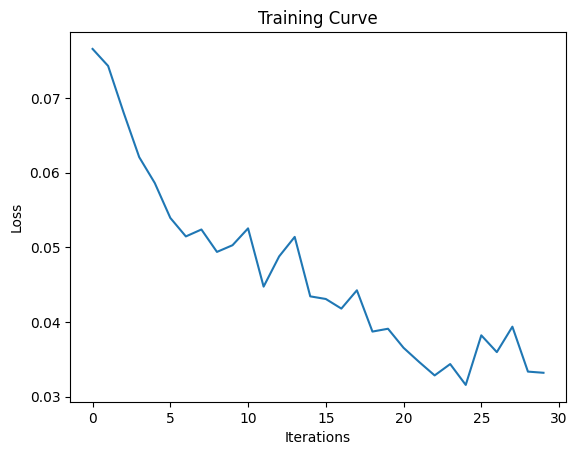

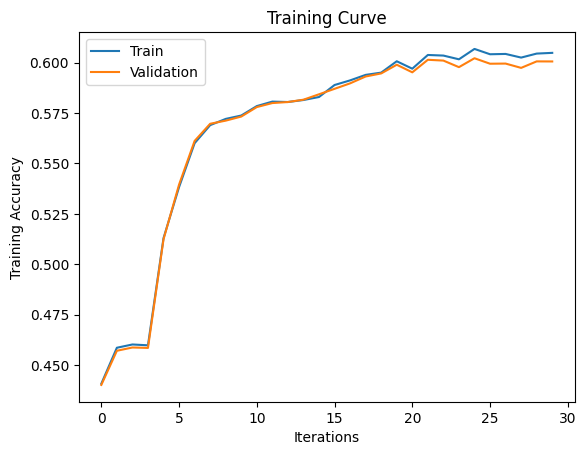

Final Training Accuracy: 0.6048119554770099
Final Validation Accuracy: 0.6005497685185185


In [ ]:
#train with 30 epoch to see the curve first
model = AutoEncoder()
train(model, train_set, val_set, num_epochs=30)

### Part (d) [5 pt]

Tune your hyperparameters, training at least 4 different models (4 sets of hyperparameters).

Do not include all your training curves. Instead, explain what hyperparameters
you tried, what their effect was, and what your thought process was as you
chose the next set of hyperparameters to try.

epoch number  1 accuracy:  0.44016835643195984
epoch number  2 accuracy:  0.45986419867919265
epoch number  3 accuracy:  0.4592906086255542
epoch number  4 accuracy:  0.4644761727591232
epoch number  5 accuracy:  0.5284004588720429
epoch number  6 accuracy:  0.5491427154063188
epoch number  7 accuracy:  0.565908597649831
epoch number  8 accuracy:  0.5702337767029424
epoch number  9 accuracy:  0.5739931169193564
epoch number  10 accuracy:  0.5769075744891948
epoch number  11 accuracy:  0.573559048770657
epoch number  12 accuracy:  0.589007224134189
epoch number  13 accuracy:  0.5941385297491706
epoch number  14 accuracy:  0.5927278082658978
epoch number  15 accuracy:  0.5905264626546368
epoch number  16 accuracy:  0.5876430099525626
epoch number  17 accuracy:  0.5899528726009984
epoch number  18 accuracy:  0.5930456081604812
epoch number  19 accuracy:  0.591069047840511
epoch number  20 accuracy:  0.5973320311288872
epoch number  21 accuracy:  0.5950299196973925
epoch number  22 accurac

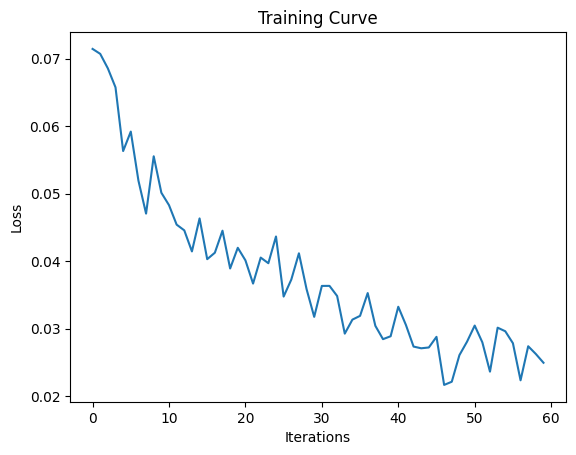

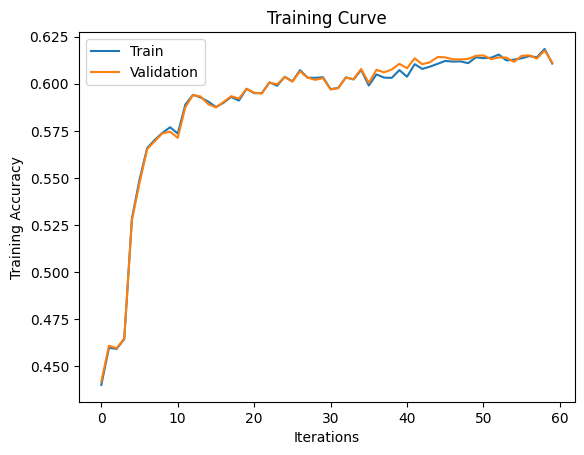

Final Training Accuracy: 0.6107493876538617
Final Validation Accuracy: 0.6112557870370371


In [ ]:
#since it is still underfitting, increase the number of epoch
model = AutoEncoder()
train(model, train_set, val_set, num_epochs=60)

epoch number  1 accuracy:  0.4561358633305429
epoch number  2 accuracy:  0.4588255356090906
epoch number  3 accuracy:  0.4630654512758503
epoch number  4 accuracy:  0.46217406132762845
epoch number  5 accuracy:  0.525548011037733
epoch number  6 accuracy:  0.5570024493845533
epoch number  7 accuracy:  0.5679549189222708
epoch number  8 accuracy:  0.5697066939509503
epoch number  9 accuracy:  0.5722490931076178
epoch number  10 accuracy:  0.5742954143800577
epoch number  11 accuracy:  0.5792794468731591
epoch number  12 accuracy:  0.5855889374631817
epoch number  13 accuracy:  0.5890382290019534
epoch number  14 accuracy:  0.5886274145040772
epoch number  15 accuracy:  0.5883871267789043
epoch number  16 accuracy:  0.5882476048739652
epoch number  17 accuracy:  0.5889762192664248
epoch number  18 accuracy:  0.5867748736551639
epoch number  19 accuracy:  0.5872476978885685
epoch number  20 accuracy:  0.5878755464607943
epoch number  21 accuracy:  0.5896583263572381
epoch number  22 accur

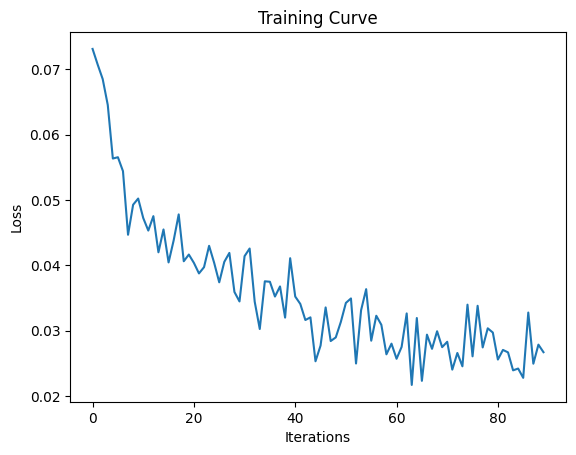

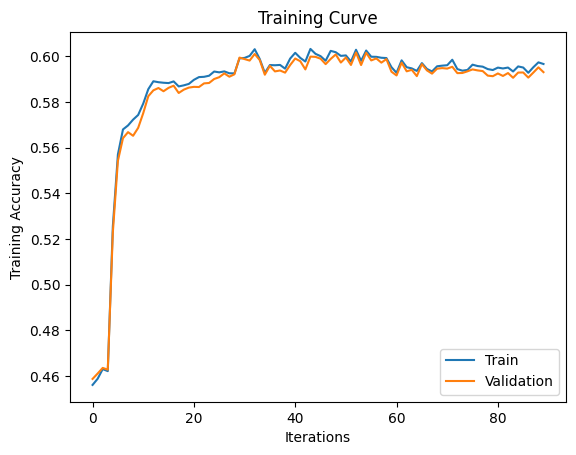

Final Training Accuracy: 0.5965956655194865
Final Validation Accuracy: 0.5930266203703703


In [ ]:
#did not converge, is still underfitting, increase epoch size
model = AutoEncoder()
train(model, train_set, val_set, num_epochs= 90)

epoch number  1 accuracy:  0.5619089697082442
epoch number  2 accuracy:  0.5893792825473599
epoch number  3 accuracy:  0.5909915356711004
epoch number  4 accuracy:  0.581868353331473
epoch number  5 accuracy:  0.5949136514432766
epoch number  6 accuracy:  0.5969754751495985
epoch number  7 accuracy:  0.601060366477537
epoch number  8 accuracy:  0.5998434254177906
epoch number  9 accuracy:  0.5981924162093448
epoch number  10 accuracy:  0.604315877592782
epoch number  11 accuracy:  0.6101602951663411
epoch number  12 accuracy:  0.607021052305212
epoch number  13 accuracy:  0.6104393389762193
epoch number  14 accuracy:  0.6116717824698478
epoch number  15 accuracy:  0.6107726413046848
epoch number  16 accuracy:  0.6140669085046352
epoch number  17 accuracy:  0.6211980280904102
epoch number  18 accuracy:  0.6217173596254612
epoch number  19 accuracy:  0.6196400334852572
epoch number  20 accuracy:  0.625189904815056
epoch number  21 accuracy:  0.6263060800545686
epoch number  22 accuracy: 

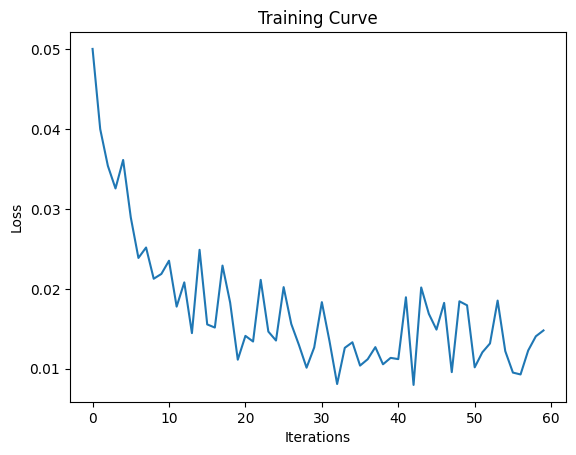

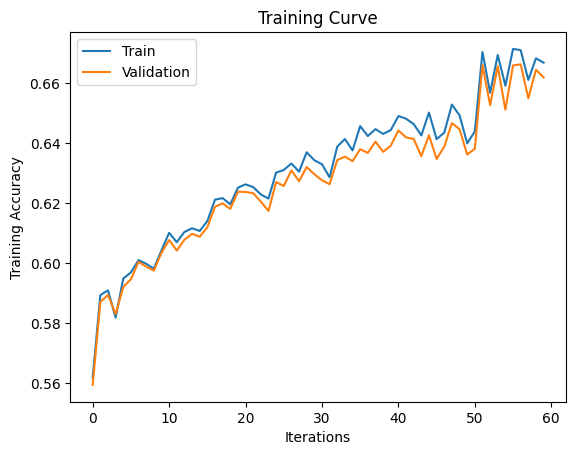

Final Training Accuracy: 0.6668604470901932
Final Validation Accuracy: 0.6619285300925926


In [ ]:
#accruacy did not change, still underfitting, so increase the learning rate to make it converge faster
model = AutoEncoder()
train(model, train_set, val_set, num_epochs=60,learning_rate = 0.001)

epoch number  1 accuracy:  0.5628391157411714
epoch number  2 accuracy:  0.584976591324838
epoch number  3 accuracy:  0.6005487861594271
epoch number  4 accuracy:  0.5973630359966515
epoch number  5 accuracy:  0.5964096363129011
epoch number  6 accuracy:  0.6020525222459926
epoch number  7 accuracy:  0.604308126375841
epoch number  8 accuracy:  0.6038818094440828
epoch number  9 accuracy:  0.6043003751588999
epoch number  10 accuracy:  0.6093154125197656
epoch number  11 accuracy:  0.6041065947353734
epoch number  12 accuracy:  0.6033547266920907
epoch number  13 accuracy:  0.610540104796453
epoch number  14 accuracy:  0.6080442129414318
epoch number  15 accuracy:  0.6111136948500915
epoch number  16 accuracy:  0.6204694136979506
epoch number  17 accuracy:  0.6187563947539764
epoch number  18 accuracy:  0.6264223483086845
epoch number  19 accuracy:  0.621686354757697
epoch number  20 accuracy:  0.6250581341270579
epoch number  21 accuracy:  0.6295460887359315
epoch number  22 accuracy:

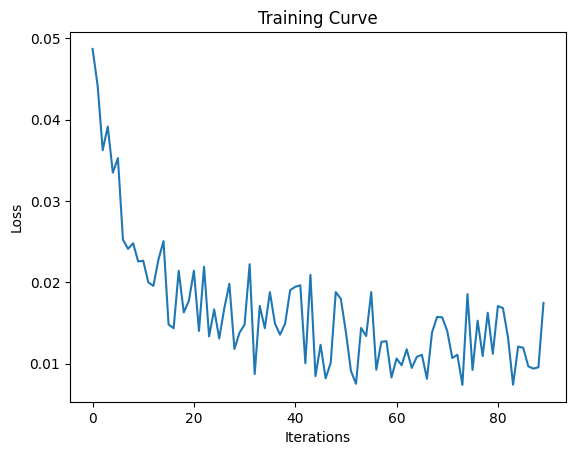

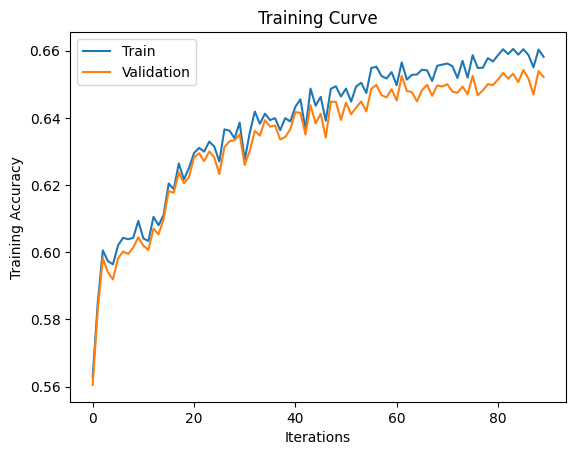

Final Training Accuracy: 0.658148079248442
Final Validation Accuracy: 0.6521629050925926


In [ ]:
#accruacy did increase, still underfitting, so increase the epoch to train longer
model = AutoEncoder()
train(model, train_set, val_set, num_epochs=90,learning_rate = 0.001)

epoch number  1 accuracy:  0.565265246643723
epoch number  2 accuracy:  0.5966499240380739
epoch number  3 accuracy:  0.6074241155861471
epoch number  4 accuracy:  0.6102843146373981
epoch number  5 accuracy:  0.6014789321923542
epoch number  6 accuracy:  0.6134313087154684
epoch number  7 accuracy:  0.6065714817226304
epoch number  8 accuracy:  0.6100052708275199
epoch number  9 accuracy:  0.6016649613989397
epoch number  10 accuracy:  0.608966607757418
epoch number  11 accuracy:  0.610013022044461
epoch number  12 accuracy:  0.6182680680866897
epoch number  13 accuracy:  0.6169813660744737
epoch number  14 accuracy:  0.6177797414194028
epoch number  15 accuracy:  0.6150513130561498
epoch number  16 accuracy:  0.6085092859578954
epoch number  17 accuracy:  0.6263215824884507
epoch number  18 accuracy:  0.6301041763556878
epoch number  19 accuracy:  0.62843766471336
epoch number  20 accuracy:  0.6321582488450687
epoch number  21 accuracy:  0.6259185192075156
epoch number  22 accuracy: 

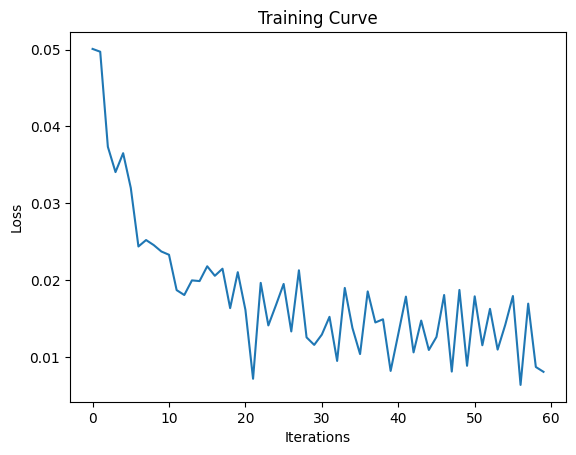

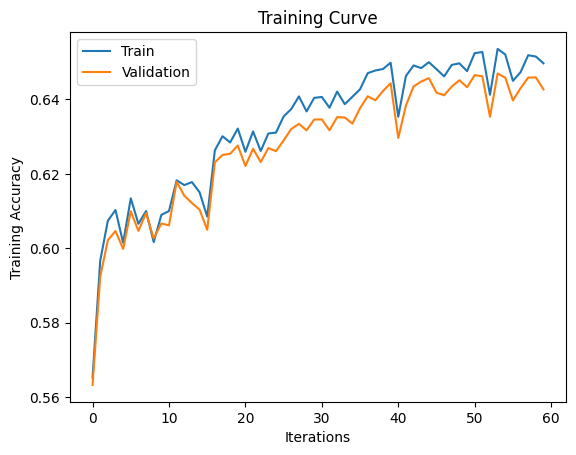

Final Training Accuracy: 0.6496915015657458
Final Validation Accuracy: 0.6426866319444444


In [ ]:
#accruacy did not change, still underfitting, so increase the learning rate to make it converge faster
model = AutoEncoder()
train_save(model, train_set, val_set, num_epochs=60,learning_rate = 0.001)

## Part 4. Testing [12 pt]

### Part (a) [2 pt]

Compute and report the test accuracy.

In [ ]:
net = AutoEncoder()
model_path = get_model_name(net.name, learning_rate=0.001, epoch=60)
state = torch.load(model_path)
net.load_state_dict(state)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=256, shuffle = True)
accuracy = get_accuracy(net, test_loader, test_loader)
print("test accuracy = ", accuracy)

test accuracy =  0.6461226851851852


### Part (b) [4 pt]

Based on the test accuracy alone, it is difficult to assess whether our model
is actually performing well. We don't know whether a high accuracy is due to
the simplicity of the problem, or if a poor accuracy is a result of the inherent
difficulty of the problem.

It is therefore very important to be able to compare our model to at least one
alternative. In particular, we consider a simple **baseline**
model that is not very computationally expensive. Our neural network
should at least outperform this baseline model. If our network is not much
better than the baseline, then it is not doing well.

For our data imputation problem, consider the following baseline model:
to predict a missing feature, the baseline model will look at the **most common value** of the feature in the training set.

For example, if the feature "marriage" is missing, then this model's prediction will be the most common value for "marriage" in the training set, which happens to be "Married-civ-spouse".

What would be the test accuracy of this baseline model?


In [ ]:
most_common = {}
for col in df_not_missing:
    most_common[col] = df_not_missing[col].value_counts().idxmax()
print(most_common)

{'age': 0.2602739726027397, 'yredu': 0.5333333333333333, 'capgain': 0.0, 'caploss': 0.0, 'workhr': 0.3979591836734694, 'work': ' Private', 'marriage': ' Married-civ-spouse', 'occupation': ' Prof-specialty', 'edu': ' HS-grad', 'relationship': ' Husband', 'sex': ' Male'}


In [ ]:
accuracy = 0
for value in df_not_missing['marriage']:
    if most_common['marriage'] == value:
        accuracy += 1
accuracy /= len(df_not_missing['marriage'])
print("test accuracy of baseline model is:",accuracy*100, "%")

test accuracy of baseline model is: 46.67947131974738 %


### Part (c) [1 pt]

How does your test accuracy from part (a) compared to your basline test accuracy in part (b)?

My test accuracy is 64.6% which is much higher than accuracy resulted from baseline model, 46.67.

### Part (d) [1 pt]

Look at the first item in your test data.
Do you think it is reasonable for a human
to be able to guess this person's education level
based on their other features? Explain.

In [ ]:
for col in cat_index:
  print(col + ": " + get_categorical_value(get_onehot(test_set[0], col), col))

work: Private
marriage: Divorced
occupation: Transport-moving
edu: HS-grad
relationship: Not-in-family
sex: Male


It is very hard to assumn once's educational level based on other features. Work and occupation might be a great indication for education level, but there remains large portion of inaccuracy.

### Part (e) [2 pt]

What is your model's prediction of this person's education
level, given their other features?


In [ ]:
data = test_set[0]
data = torch.from_numpy(data)

net = AutoEncoder()
model_path = get_model_name(net.name, learning_rate=0.001, epoch=60)
state = torch.load(model_path)
net.load_state_dict(state)
result = net(data)
inp = result.detach().numpy()
print("edu" + ": " + get_categorical_value(get_onehot(inp, 'edu'), 'edu'))


edu: HS-grad


### Part (f) [2 pt]

What is the baseline model's prediction
of this person's education level?

In [ ]:
print(most_common["edu"])

 HS-grad
